# Introduction

In this notebook, we will try to find the underlying **relationships between the 14 coins** as suggested in the introductory notebook by the competition host. 
> We encourage participants to perform additional statistical analyses to have a stronger grasp on the dataset, including autocorrelation, time-series decomposition and stationarity tests. - [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)

Along the way, we intend to interpret our findings in the hope of providing some **domain knowledge** about the crypto scene (which is also going to include a few memes).
<img src="https://media.giphy.com/media/YkYt0FzMNPJkFnSQlf/giphy.gif" style="width: 800px;">

<a href="https://giphy.com/gifs/carlos-scam-bitconnect-YkYt0FzMNPJkFnSQlf">via GIPHY</a>

In [1]:
# !pip install plotly seaborn statsmodels

# Summary

- Correlation between coins highly varies over time
- Similarly to share prices, coin prices seem to follow a **random walk** pattern, which is difficult to predict


In [3]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

from datetime import datetime

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


data_folder = "./g-research-crypto-forecasting/"

asset_details = pd.read_csv(data_folder + 'asset_details.csv', low_memory=False)
train = pd.read_csv(data_folder + 'train.csv', low_memory=False)
#supplemental_train = pd.read_csv(data_folder + 'supplemental_train.csv', low_memory=False)
#example_test = pd.read_csv(data_folder + 'example_test.csv', low_memory=False)
#example_sample_submission = pd.read_csv(data_folder + 'example_sample_submission.csv', low_memory=False)

rename_dict = {}
for a in asset_details['Asset_ID']:
    rename_dict[a] = asset_details[asset_details.Asset_ID == a].Asset_Name.values[0]

#display(asset_details)

In [5]:
# relationship between 14 crypto

In [4]:
rename_dict

{2: 'Bitcoin Cash',
 0: 'Binance Coin',
 1: 'Bitcoin',
 5: 'EOS.IO',
 7: 'Ethereum Classic',
 6: 'Ethereum',
 9: 'Litecoin',
 11: 'Monero',
 13: 'TRON',
 12: 'Stellar',
 3: 'Cardano',
 8: 'IOTA',
 10: 'Maker',
 4: 'Dogecoin'}

In [6]:
index = pd.date_range(start='22:51:01 05/24/2019',
                      end='02:54:22 05/25/2019',
                      periods=5)
table = np.random.randint(np.arange(5), np.arange(5, 10), size=[5, 5])
np.random.seed(seed=10)
df = pd.DataFrame([[chr(y + np.random.randint(50, 100)) for y in x]
                   for x in table.tolist()],
                  index=index)
df


0  1  2  3  4
2019-05-24 22:51:01.000  <  Z  F  5  g
2019-05-24 23:51:51.250  P  M  Q  i  W
2019-05-25 00:52:41.500  e  ?  >  8  d
2019-05-25 01:53:31.750  ]  X  D  Y  h
2019-05-25 02:54:22.000  A  L  `  W  >

In [6]:
df.resample('s').sum().shape

(14602, 5)

# Preprocessing

For the following EDA, we will **resample the minute-wise crypto data to daily samples**. This reduces the amount of samples from 24,236,806 to 1,360. 

In [9]:
# Convert timestamp
train['timestamp'] = train['timestamp'].astype('datetime64[s]')
#supplemental_train['timestamp'] = supplemental_train['timestamp'].astype('datetime64[s]')
#example_test['timestamp'] = example_test['timestamp'].astype('datetime64[s]')

#train['date'] = pd.DatetimeIndex(train['timestamp']).date
#supplemental_train['date'] = pd.DatetimeIndex(supplemental_train['timestamp']).date
#example_test['date'] = pd.DatetimeIndex(example_test['timestamp']).date

# Resample
train_daily = pd.DataFrame()

for asset_id in asset_details.Asset_ID:
    train_single = train[train.Asset_ID == asset_id].copy()
    #BL resample the data by a day FRAME.
    train_single_new = train_single[['timestamp','Count']].resample('D', on='timestamp').sum()
    train_single_new['Open'] = train_single[['timestamp','Open']].resample('D', on='timestamp').first()['Open']
    train_single_new['High'] = train_single[['timestamp','High']].resample('D', on='timestamp').max()['High']
    train_single_new['Low'] = train_single[['timestamp','Low']].resample('D', on='timestamp').min()['Low']
    train_single_new['Close'] = train_single[['timestamp','Close']].resample('D', on='timestamp').last()['Close']
    train_single_new['Volume'] = train_single[['timestamp','Volume']].resample('D', on='timestamp').sum()['Volume']
    # train_single_new['VWAP']
    #train_single_new['Target'] = train_single[['timestamp','Target']].resample('D', on='timestamp').mean()['Target']
    train_single_new['Asset_ID'] = asset_id

    train_daily = train_daily.append(train_single_new.reset_index(drop=False))
train_daily = train_daily.sort_values(by = ['timestamp', 'Asset_ID']).reset_index(drop=True)

train_daily = train_daily.pivot(index='timestamp', columns='Asset_ID')[['Count', 'Open', 'High', 'Low', 'Close', 'Volume']]
train_daily = train_daily.reset_index(drop=False)
train_daily['year'] = pd.DatetimeIndex(train_daily['timestamp']).year
train_daily['month'] = pd.DatetimeIndex(train_daily['timestamp']).month

display(train_daily.head(10))

timestamp    Count                                                 \
Asset_ID                   0         1         2   3   4        5         6   
0        2018-01-01  18200.0  365257.0   59257.0 NaN NaN  13640.0  178492.0   
1        2018-01-02  29923.0  574564.0  114865.0 NaN NaN  26127.0  405855.0   
2        2018-01-03  24572.0  518239.0  104420.0 NaN NaN  25961.0  335488.0   
3        2018-01-04  26176.0  565945.0  100805.0 NaN NaN  46104.0  363372.0   
4        2018-01-05  44906.0  595440.0  114272.0 NaN NaN  24917.0  369258.0   
5        2018-01-06  59765.0  468565.0  174319.0 NaN NaN  23286.0  262719.0   
6        2018-01-07  40098.0  386388.0  181473.0 NaN NaN  31543.0  258599.0   
7        2018-01-08  43734.0  592165.0  125114.0 NaN NaN  38313.0  482598.0   
8        2018-01-09  38047.0  485952.0   93463.0 NaN NaN  18704.0  409380.0   
9        2018-01-10  38643.0  581870.0  186286.0 NaN NaN  43536.0  542941.0   

                                                         Open              \
Asset_ID        7   8         9  10       11  12  13        0           1   
0         35134.0 NaN  120933.0 NaN   8536.0 NaN NaN   8.5300  13835.1940   
1         37735.0 NaN  247746.0 NaN  15632.0 NaN NaN   8.4500  13427.4920   
2         26211.0 NaN  192320.0 NaN  13015.0 NaN NaN   8.7151  14748.2960   
3         42602.0 NaN  230012.0 NaN  14636.0 NaN NaN   9.3040  15102.0120   
4         34991.0 NaN  213587.0 NaN  14718.0 NaN NaN   9.1350  15154.7660   
5         23654.0 NaN  319601.0 NaN  15203.0 NaN NaN  14.8908  16949.7380   
6         27046.0 NaN  159961.0 NaN  23806.0 NaN NaN  22.6000  17112.7440   
7         49444.0 NaN  216246.0 NaN  18315.0 NaN NaN  18.5375  16195.0125   
8         37798.0 NaN  168841.0 NaN  28652.0 NaN NaN  18.0400  14963.8320   
9         48305.0 NaN  197737.0 NaN  21149.0 NaN NaN  17.3992  14447.8020   

                                                                              \
Asset_ID            2   3   4        5          6        7   8         9  10   
0         2376.580000 NaN NaN   7.6596   738.3025  25.9200 NaN  225.3300 NaN   
1         2320.886667 NaN NaN   7.6401   756.2250  29.4995 NaN  223.7400 NaN   
2         2553.570000 NaN NaN   8.3205   860.1475  31.8710 NaN  251.2200 NaN   
3         2558.480000 NaN NaN   9.4300   937.8450  33.1945 NaN  243.0260 NaN   
4         2358.280000 NaN NaN   9.4704   942.9225  34.0655 NaN  237.5340 NaN   
5         2390.105000 NaN NaN   9.2895   961.8650  31.1195 NaN  243.1900 NaN   
6         2527.460000 NaN NaN   9.8256  1003.3450  33.9570 NaN  278.1775 NaN   
7         2524.895000 NaN NaN  10.1510  1113.7975  35.3650 NaN  270.9875 NaN   
8         2405.666667 NaN NaN   9.5834  1133.8975  33.7060 NaN  253.6000 NaN   
9         2373.106667 NaN NaN   9.2353  1287.2025  37.6630 NaN  245.5300 NaN   

                              High                                             \
Asset_ID       11  12  13        0        1       2   3   4        5        6   
0         329.090 NaN NaN   8.7000  14442.9  2444.0 NaN NaN   7.9500   772.98   
1         340.350 NaN NaN   9.1133  15500.0  2745.5 NaN NaN   8.6000   899.50   
2         365.160 NaN NaN   9.4697  15599.7  2789.0 NaN NaN   9.4345   954.73   
3         385.030 NaN NaN   9.6511  15500.1  2577.1 NaN NaN  10.5030  1009.72   
4         372.500 NaN NaN  16.8172  17200.0  2530.9 NaN NaN   9.8500  1045.00   
5         356.125 NaN NaN  23.6000  17252.0  2649.0 NaN NaN   9.8990  1017.56   
6         391.010 NaN NaN  22.6599  17178.0  2758.9 NaN NaN  10.9000  1125.00   
7         397.775 NaN NaN  19.2999  16322.3  2590.2 NaN NaN  10.3900  1239.18   
8         401.435 NaN NaN  20.6114  15500.0  2493.0 NaN NaN   9.7429  1326.50   
9         409.870 NaN NaN  17.5554  14979.0  2956.0 NaN NaN  11.4800  1440.00   

                                                      Low                    \
Asset_ID       7   8       9  10      11  12  13        0         1       2   
0         32.500 NaN  237.77 NaN  348.30 NaN

# Data Overview

Furthermore, we have samples from 2018-01-01 to 2021-09-21 for the majority of coins. For TRON, Stellar, Cardano, IOTA, Maker, and Dogecoin we have fewer data starting from later in 2018 or even later in 2019 in Dogecoin's case.

In [11]:
# Visualize
fig = make_subplots(
    rows=len(asset_details.Asset_ID), cols=1,
    subplot_titles=(asset_details.Asset_Name)
)

for i, asset_id in enumerate(asset_details.Asset_ID):
    fig.append_trace(go.Candlestick(x=train_daily.timestamp, 
                                         open=train_daily[('Open', asset_id)], 
                                         high=train_daily[('High', asset_id)], 
                                         low=train_daily[('Low', asset_id)], 
                                         close=train_daily[('Close', asset_id)]),
                  row=i+1, col=1,
                    )

    fig.update_xaxes(range=[train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]], row=i+1, col=1)


fig.update_layout(xaxis_rangeslider_visible = False, 
                  xaxis2_rangeslider_visible = False, 
                  xaxis3_rangeslider_visible = False,
                  xaxis4_rangeslider_visible = False,
                  xaxis5_rangeslider_visible = False,
                  xaxis6_rangeslider_visible = False,
                  xaxis7_rangeslider_visible = False,
                  xaxis8_rangeslider_visible = False,
                  xaxis9_rangeslider_visible = False,
                  xaxis10_rangeslider_visible = False,
                  xaxis11_rangeslider_visible = False,
                  xaxis12_rangeslider_visible = False,
                  xaxis13_rangeslider_visible = False,
                  xaxis14_rangeslider_visible = False,
                  height=3000, width=800, 
                  #title_text="Subplots with Annotations"
                      margin = dict(
        l = 0,
        r = 0,
        b = 0,
        t = 30,
        pad = 0)
                 )
                 
fig.show()

# Stationarity

The 'Close' prices seem to be mostly non-stationary. However, Bitcoin and Ethereum seem to be stationary.

In [43]:
print(asset_details)

    Asset_ID    Weight        Asset_Name
0          2  2.397895      Bitcoin Cash
1          0  4.304065      Binance Coin
2          1  6.779922           Bitcoin
3          5  1.386294            EOS.IO
4          7  2.079442  Ethereum Classic
5          6  5.894403          Ethereum
6          9  2.397895          Litecoin
7         11  1.609438            Monero
8         13  1.791759              TRON
9         12  2.079442           Stellar
10         3  4.406719           Cardano
11         8  1.098612              IOTA
12        10  1.098612             Maker
13         4  3.555348          Dogecoin


In [67]:
train_daily

(1360, 101)

In [50]:
import dabl

In [95]:
train_daily[('Close', 1)].mean()

15652.306093192648

In [10]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, asset_id):
    # Copied and edited from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}: \u001b[32mStationary\u001b[0m")
    else:
        print(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}: \x1b[31mNon-stationary\x1b[0m")
       
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')

for i, asset_id in enumerate(asset_details.Asset_ID):    
    check_stationarity(train_daily[('Close', i)].fillna(0), asset_id)

Bitcoin Cash: Non-stationary
ADF Statistic: -1.159645
p-value: 0.690710
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Binance Coin: Non-stationary
ADF Statistic: -0.422392
p-value: 0.906293
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Bitcoin: Stationary
ADF Statistic: -4.032213
p-value: 0.001251
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


EOS.IO: Non-stationary
ADF Statistic: -0.587023
p-value: 0.873887
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Ethereum Classic: Non-stationary
ADF Statistic: -1.834981
p-value: 0.363238
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Ethereum: Stationary
ADF Statistic: -3.299994
p-value: 0.014879
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Litecoin: Non-stationary
ADF Statistic: 0.149049
p-value: 0.969255
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Monero: Non-stationary
ADF Statistic: -1.827470
p-value: 0.366911
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


TRON: 

To make a time series stationary, you can try differencing it. In this case, we will use the log return instead as shown below.

In [54]:
# define function to compute log returns
def log_return(series, periods=1):
    # Copied from https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition
    return np.log(series).diff(periods=periods)


for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('lret',  asset_id)] = log_return(train_daily[( 'Close',  asset_id)])

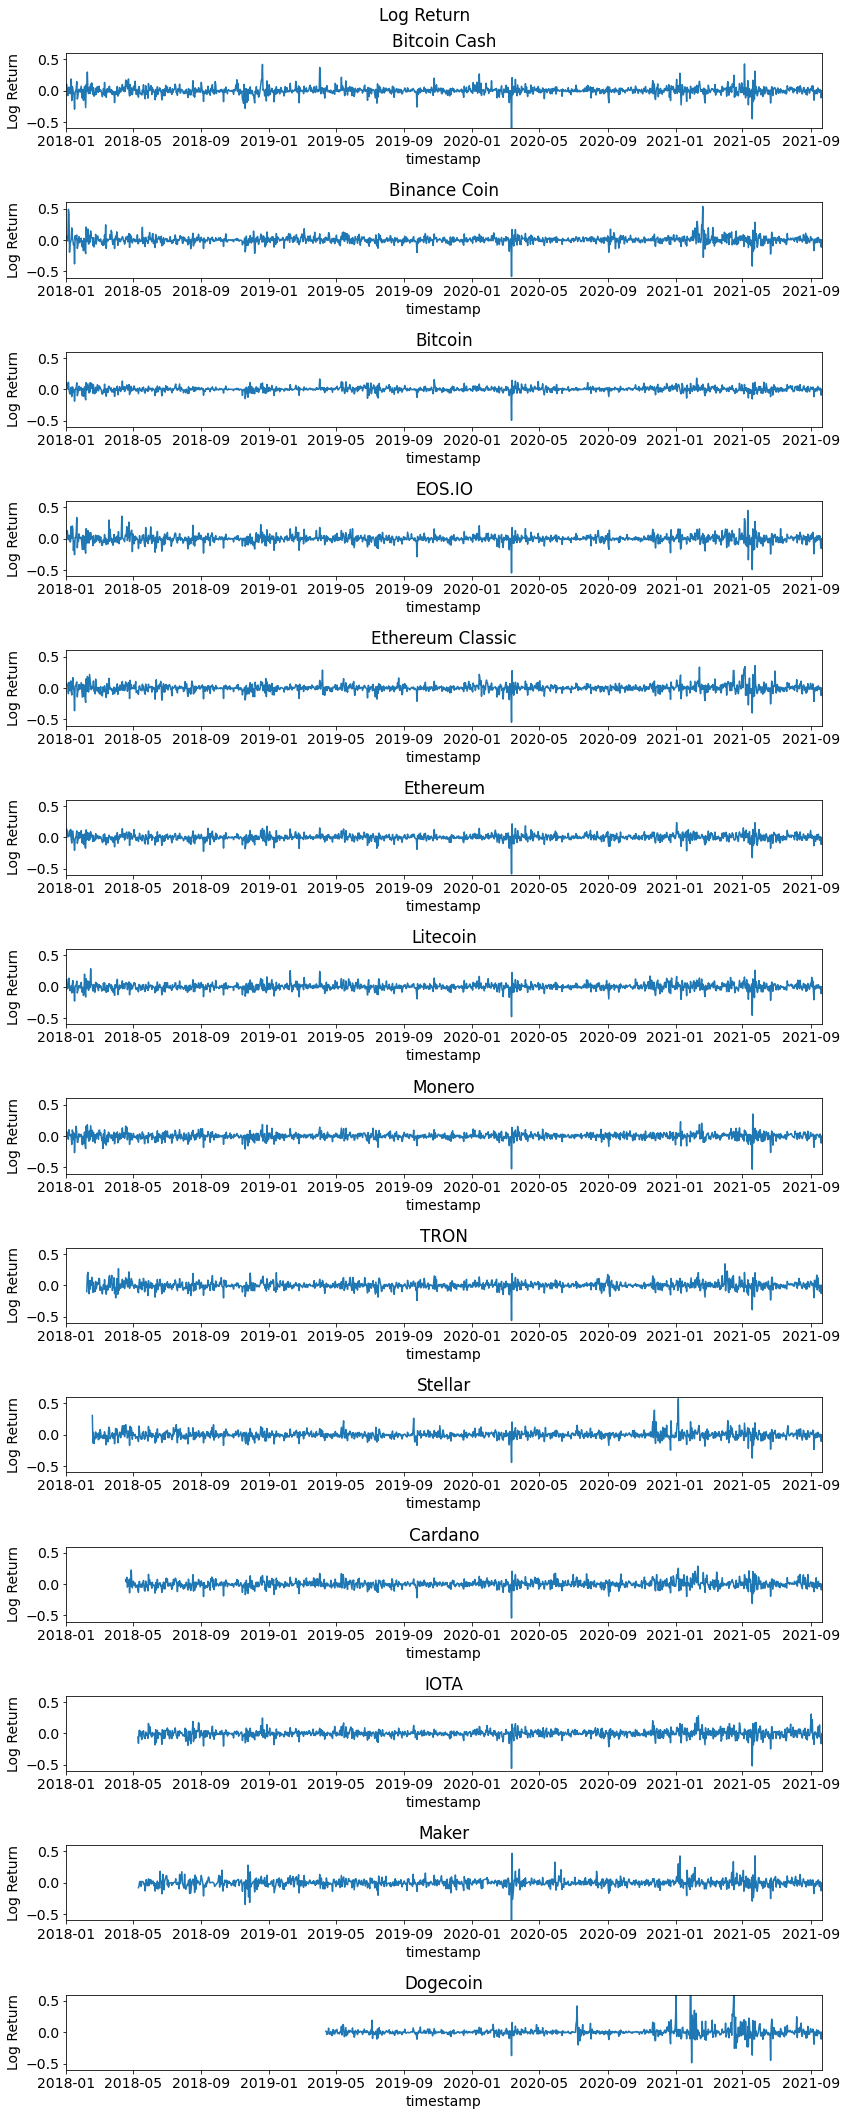

In [55]:
# Visualize
f, ax = plt.subplots(nrows=len(asset_details.Asset_ID), ncols=1, figsize=(12, 30))
for i, asset_id in enumerate(asset_details.Asset_ID):

    sns.lineplot(data=train_daily, x='timestamp', y = ( 'lret',  asset_id) , ax=ax[i]);
    ax[i].set_title(asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0])
    ax[i].set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
    ax[i].set_ylim([-0.6,0.6])
    ax[i].set_ylabel('Log Return')
plt.suptitle('Log Return\n')

plt.tight_layout()
plt.show()

The log returns seem to be stationary.

In [7]:
for i, asset_id in enumerate(asset_details.Asset_ID):    
    check_stationarity(train_daily[('lret', i)].fillna(0), asset_id)

Bitcoin Cash: Stationary
ADF Statistic: -10.675228
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Binance Coin: Stationary
ADF Statistic: -25.601031
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Bitcoin: Stationary
ADF Statistic: -16.586814
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


EOS.IO: Stationary
ADF Statistic: -16.980850
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Ethereum Classic: Stationary
ADF Statistic: -8.504782
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Ethereum: Stationary
ADF Statistic: -20.504873
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Litecoin: Stationary
ADF Statistic: -11.181324
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Monero: Stationary
ADF Statistic: -17.122257
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


TRON: Stationary
ADF S

In [59]:
asset_details

Asset_ID    Weight        Asset_Name
0          2  2.397895      Bitcoin Cash
1          0  4.304065      Binance Coin
2          1  6.779922           Bitcoin
3          5  1.386294            EOS.IO
4          7  2.079442  Ethereum Classic
5          6  5.894403          Ethereum
6          9  2.397895          Litecoin
7         11  1.609438            Monero
8         13  1.791759              TRON
9         12  2.079442           Stellar
10         3  4.406719           Cardano
11         8  1.098612              IOTA
12        10  1.098612             Maker
13         4  3.555348          Dogecoin

## COVID-19 Impact

In the above plots for the log returns, we can see a negative peak around March 2020. If we have a closer look at the log return of e.g. Bitcoin, we can see that this was the impact of the COVID-19 pandemic.

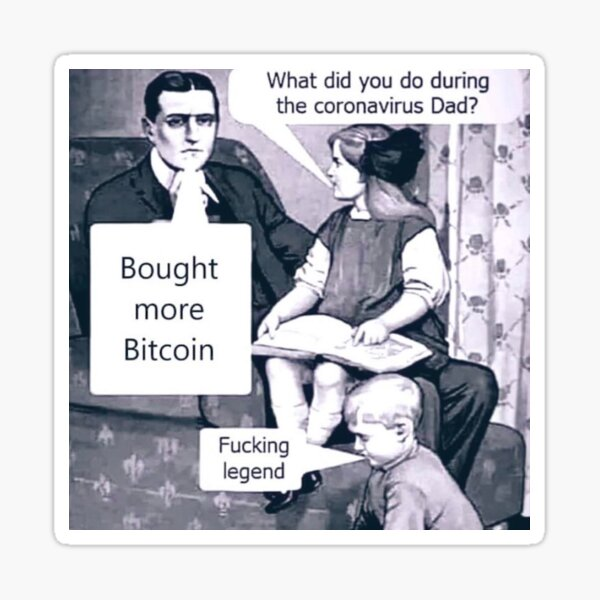

<a href="https://www.redbubble.com/de/i/sticker/Kaufte-mehr-Bitcoin-von-SecretPastures/68916371.EJUG5">via RedBubble</a>


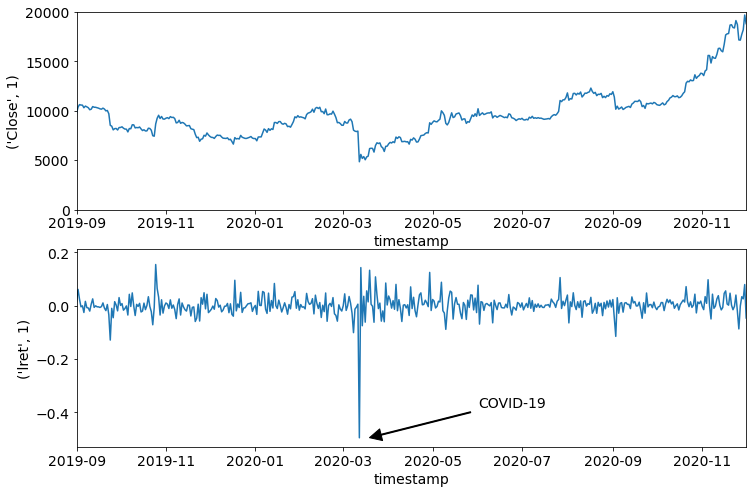

In [78]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

sns.lineplot(data=train_daily, x='timestamp', y = ( 'Close',  1) , ax=ax[0]);
sns.lineplot(data=train_daily, x='timestamp', y = ( 'lret',  1) , ax=ax[1]);
ax[0].set_xlim([pd.Timestamp('2019-09-01'), pd.Timestamp('2020-12-01')])
ax[0].set_ylim([0, 20000])

ax[1].set_xlim([pd.Timestamp('2019-09-01'), pd.Timestamp('2020-12-01')])
ax[1].annotate('COVID-19', xy=(pd.Timestamp('2020-03-15'), -0.5),  xycoords='data',
            xytext=(0.6, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            #horizontalalignment='right', verticalalignment='top',
            )
plt.show()

In [76]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

The log return is also a good indicator of the volatility.

# Correlation

> Among cryptocurrency assets with substantial valuations, **correlation is an on-and-off affair**. Bitcoin prices have set investor and price momentum in crypto markets for most of the last decade. Lately, however, as other cryptocurrencies have garnered popularity with developers and investors, that **correlation has proven difficult to maintain**. **For example, bitcoin prices fell even as prices for Ethereum’s ether (ETH) rose to new heights in early 2018.** - [Correlations Within The Context of Cryptocurrencies](https://www.gemini.com/cryptopedia/asset-correlation-between-cryptocurrencies#section-establishing-correlations-between-cryptocurrencies)

In [80]:
# Visualize
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(['Bitcoin', 'Ethereum'])
)

for i, asset_id in enumerate([1, 6]):
    fig.append_trace(go.Candlestick(x=train_daily.timestamp, 
                                         open=train_daily[('Open', asset_id)], 
                                         high=train_daily[('High', asset_id)], 
                                         low=train_daily[('Low', asset_id)], 
                                         close=train_daily[('Close', asset_id)]),
                  row=i+1, col=1,
                    )

    fig.update_xaxes(range=[pd.Timestamp('2018-06-01'), pd.Timestamp('2018-08-01')], row=i+1, col=1)

fig.update_yaxes(range=[0, 20000], row=1, col=1)
fig.update_yaxes(range=[0, 2000], row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible = False, 
                  xaxis2_rangeslider_visible = False, 
                  #height=3000, 
                  width=800, 
                  #title_text="Subplots with Annotations"
                      margin = dict(
        l = 0,
        r = 0,
        b = 0,
        t = 30,
        pad = 0)
                 )
                 
fig.show()

In [93]:
train_daily

timestamp     Count                                            \
Asset_ID                    0          1         2          3         4   
0        2018-01-01   18200.0   365257.0   59257.0        NaN       NaN   
1        2018-01-02   29923.0   574564.0  114865.0        NaN       NaN   
2        2018-01-03   24572.0   518239.0  104420.0        NaN       NaN   
3        2018-01-04   26176.0   565945.0  100805.0        NaN       NaN   
4        2018-01-05   44906.0   595440.0  114272.0        NaN       NaN   
...             ...       ...        ...       ...        ...       ...   
1355     2021-09-17  410140.0  2125227.0  179722.0   619634.0  881723.0   
1356     2021-09-18  385184.0  1830084.0  124883.0   516512.0  316042.0   
1357     2021-09-19  390485.0  1685481.0  160475.0   545423.0  283771.0   
1358     2021-09-20  809529.0  4099658.0  318167.0  1778243.0  967230.0   
1359     2021-09-21     429.0     2698.0     403.0      677.0     537.0   

                                                                      \
Asset_ID         5          6         7         8         9       10   
0          13640.0   178492.0   35134.0       NaN  120933.0      NaN   
1          26127.0   405855.0   37735.0       NaN  247746.0      NaN   
2          25961.0   335488.0   26211.0       NaN  192320.0      NaN   
3          46104.0   363372.0   42602.0       NaN  230012.0      NaN   
4          24917.0   369258.0   34991.0       NaN  213587.0      NaN   
...            ...        ...       ...       ...       ...      ...   
1355      967100.0  1959093.0  178114.0  354246.0  387779.0  67824.0   
1356      486437.0  1561221.0  121426.0  118307.0  246875.0  25979.0   
1357      391565.0  1483882.0  117056.0   69829.0  243400.0  29246.0   
1358      894685.0  3858093.0  344337.0  159594.0  681977.0  82657.0   
1359         450.0     2205.0     212.0      82.0     775.0     34.0   

                                             Open                             \
Asset_ID        11        12         13         0             1            2   
0           8536.0       NaN        NaN    8.5300  13835.194000  2376.580000   
1          15632.0       NaN        NaN    8.4500  13427.492000  2320.886667   
2          13015.0       NaN        NaN    8.7151  14748.296000  2553.570000   
3          14636.0       NaN        NaN    9.3040  15102.012000  2558.480000   
4          14718.0       NaN        NaN    9.1350  15154.766000  2358.280000   
...            ...       ...        ...       ...           ...          ...   
1355       55109.0  296404.0  1015040.0  424.2285  47759.261429   639.145000   
1356       53387.0  168526.0   444209.0  406.8265  47297.769495   621.340000   
1357       69629.0  153204.0   443534.0  410.7365  48304.237500   630.674000   
1358      123434.0  413570.0  1072720.0  408.6160  47247.514286   608.938000   
1359          48.0     177.0      380.0  364.1150  43009.961250   542.093333   

                                                                       \
Asset_ID         3         4        5            6         7        8   
0              NaN       NaN  7.65960   738.302500  25.92000      NaN   
1              NaN       NaN  7.64010   756.225000  29.49950      NaN   
2              NaN       NaN  8.32050   860.147500  31.87100      NaN   
3              NaN       NaN  9.43000   937.845000  33.19450      NaN   
4              NaN       NaN  9.47040   942.922500  34.06550      NaN   
...            ...       ...      ...          ...       ...      ...   
1355      2.417831  0.241926  5.01838  3569.237143  57.99490  1.50045   
1356      2.350670  0.240121  5.25130  3399.945714  56.69520  1.71880   
1357      2.370903  0.241376  5.46862  3435.434122  57.18920  1.64075   
1358      2.283034  0.233022  4.90818  3329.344674  55.34724  1.51090   
1359      2.081135  0.208622  4.20124  2976.858333  49.09330  1.28425   

                                                                       High  \
Asset_ID           9       

Furthermore, we can see that the relationship between the different coins can highly vary depending on the year, we are observing.

C:\Users\Badr\AppData\Local\Temp/ipykernel_17516/2753040610.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



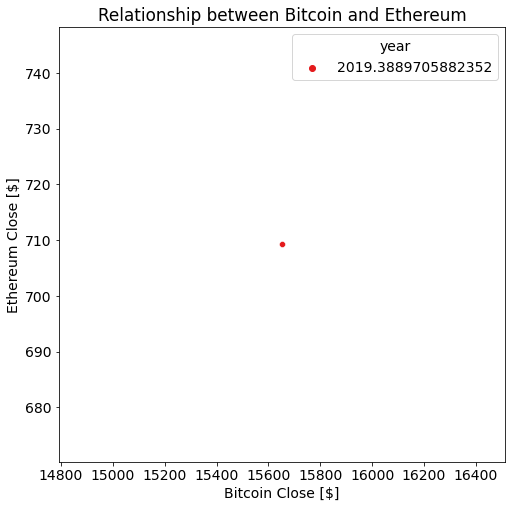

In [81]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.scatterplot(data=train_daily/train_daily.mean(), x=('Close', 1), y=('Close', 6), hue='year', palette='Set1')
ax.set_xlabel('Bitcoin Close [$]')
ax.set_ylabel('Ethereum Close [$]')
ax.set_title('Relationship between Bitcoin and Ethereum')
plt.show()

# Autocorrelation and Partial Autocorrelation

For in depth explanation on Autocorrelation analysis see: [Time Series: Interpreting ACF and PACF](https://www.kaggle.com/iamleonie/time-series-interpreting-acf-and-pacf)

For the majority of the coins it looks like we have a slight negative correlation at a lag of 1. For the other lags, it looks like the autocorrelations are statistically insignificant. This could indicate, that we have some **Random-Walk behavior, which is going to make the prediction challenging**.

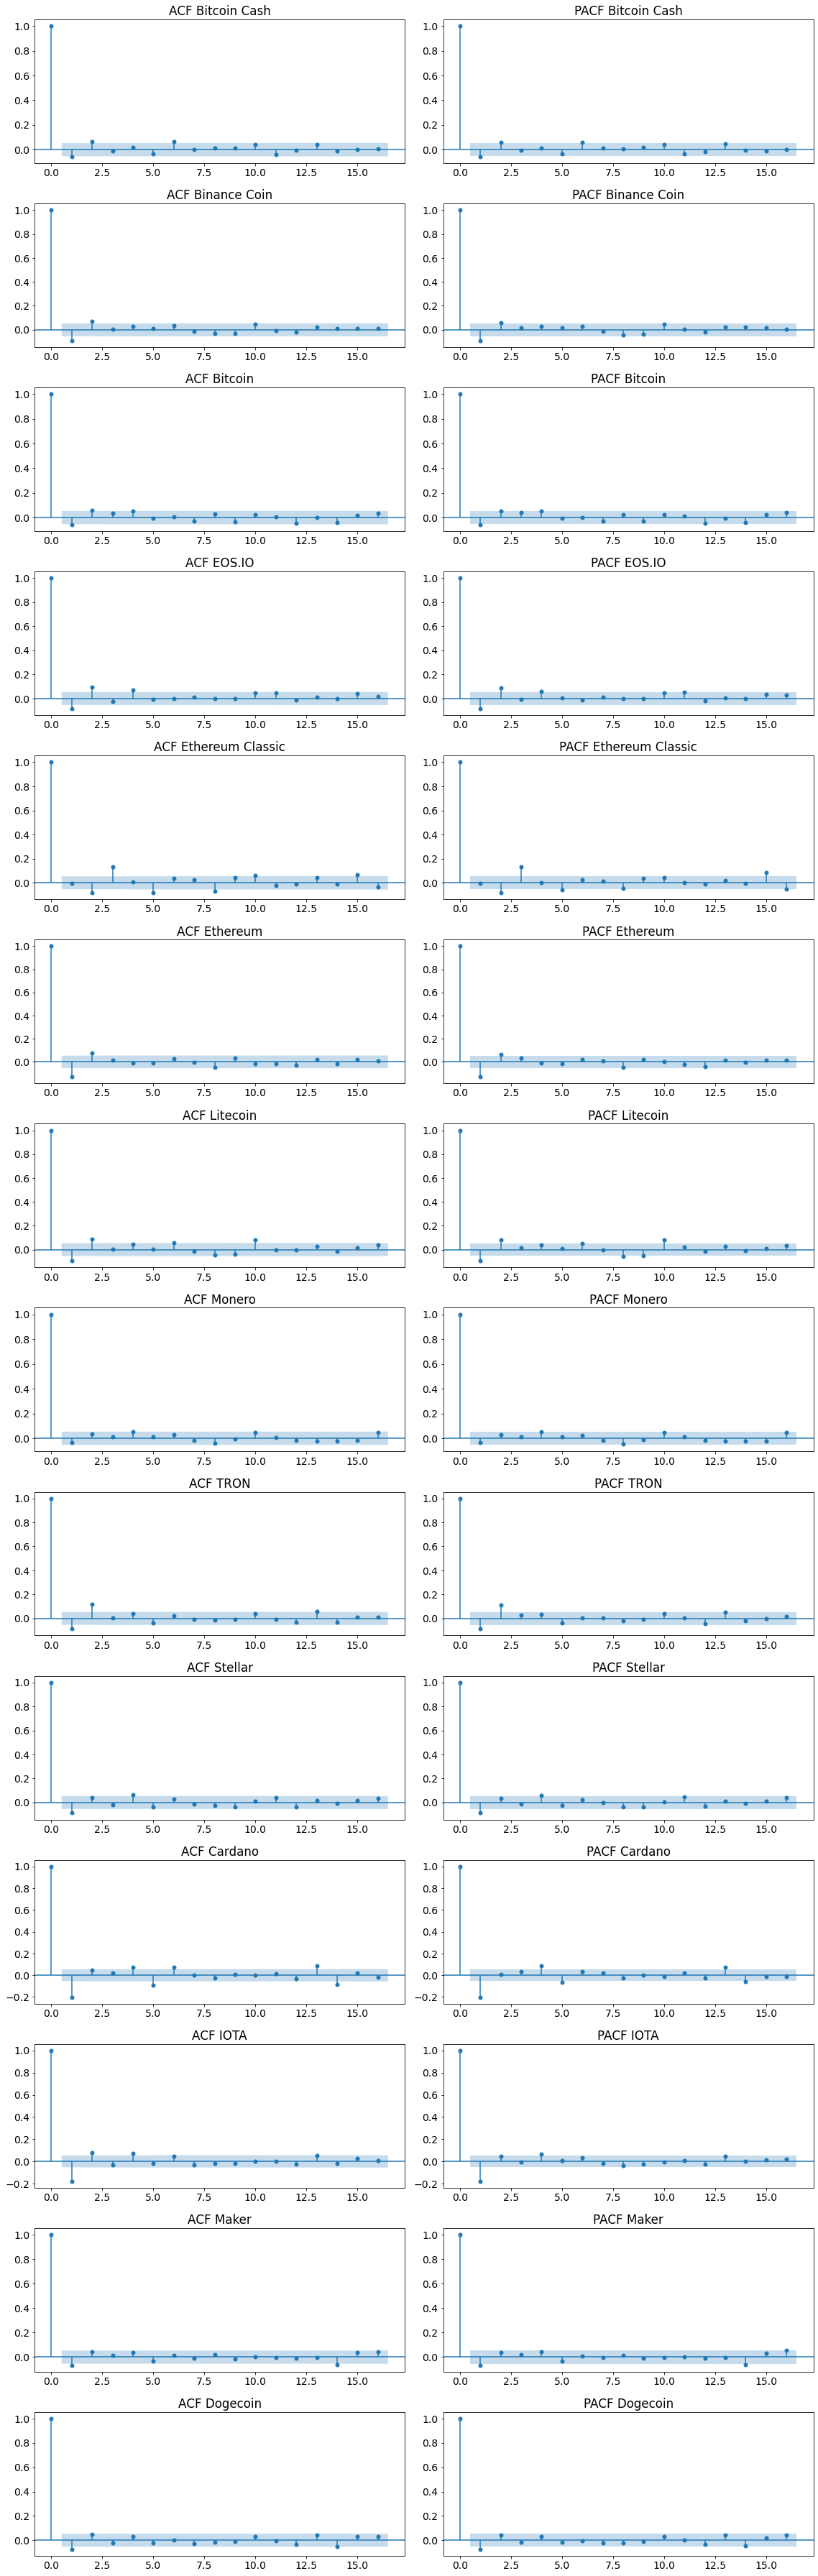

In [11]:
# Visualize
f, ax = plt.subplots(nrows=len(asset_details.Asset_ID), ncols=2, figsize=(16, 50))
for i, asset_id in enumerate(asset_details.Asset_ID):
    plot_acf(train_daily[('lret', i)].fillna(0), lags=16, ax=ax[i, 0], title=f"ACF {asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}")
    plot_pacf(train_daily[('lret', i)].fillna(0), lags=16, method='ols', ax=ax[i, 1], title=f"PACF {asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}")
    
plt.tight_layout()
plt.show()

However, if we plot the scatterplot between e.g. Ethereum and its correlation with itself with a lag of 1, it is difficult to see a linear behaviour.

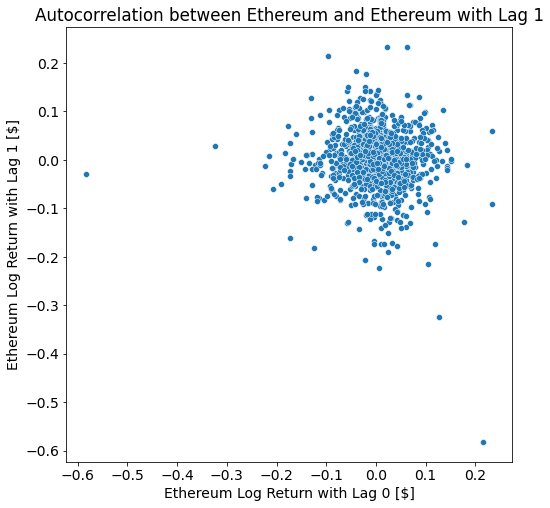

In [12]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.scatterplot(x=train_daily[('lret', 6)], y=train_daily[('lret', 6)].shift(1))
ax.set_xlabel('Ethereum Log Return with Lag 0 [$]')
ax.set_ylabel('Ethereum Log Return with Lag 1 [$]')
ax.set_title('Autocorrelation between Ethereum and Ethereum with Lag 1')
plt.show()

However, we can still create a new feature for lag of 1 with the `.shift()` function.

In [13]:
for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('lret -1',  asset_id)] = train_daily[('lret',  asset_id)].shift(1)

# Time-Series Decomposition
Since predicting random walks is quite challenging, let's see if we can at least decompose the time series and see if we can find an underlying trend.

So, **are we going to the moon or not**. That is the big question.

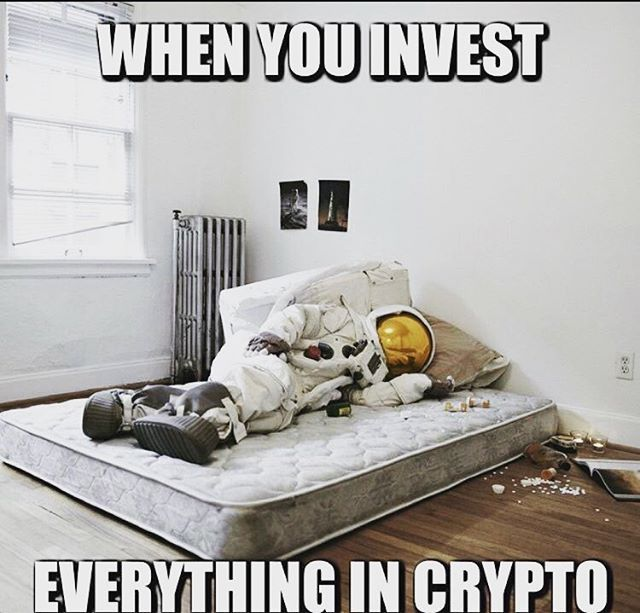

<a href="https://www.reddit.com/r/CryptoCurrency/comments/ltqlz9/what_happens_when_you_invest_in_crypto_you_go_to/">via reddit</a>



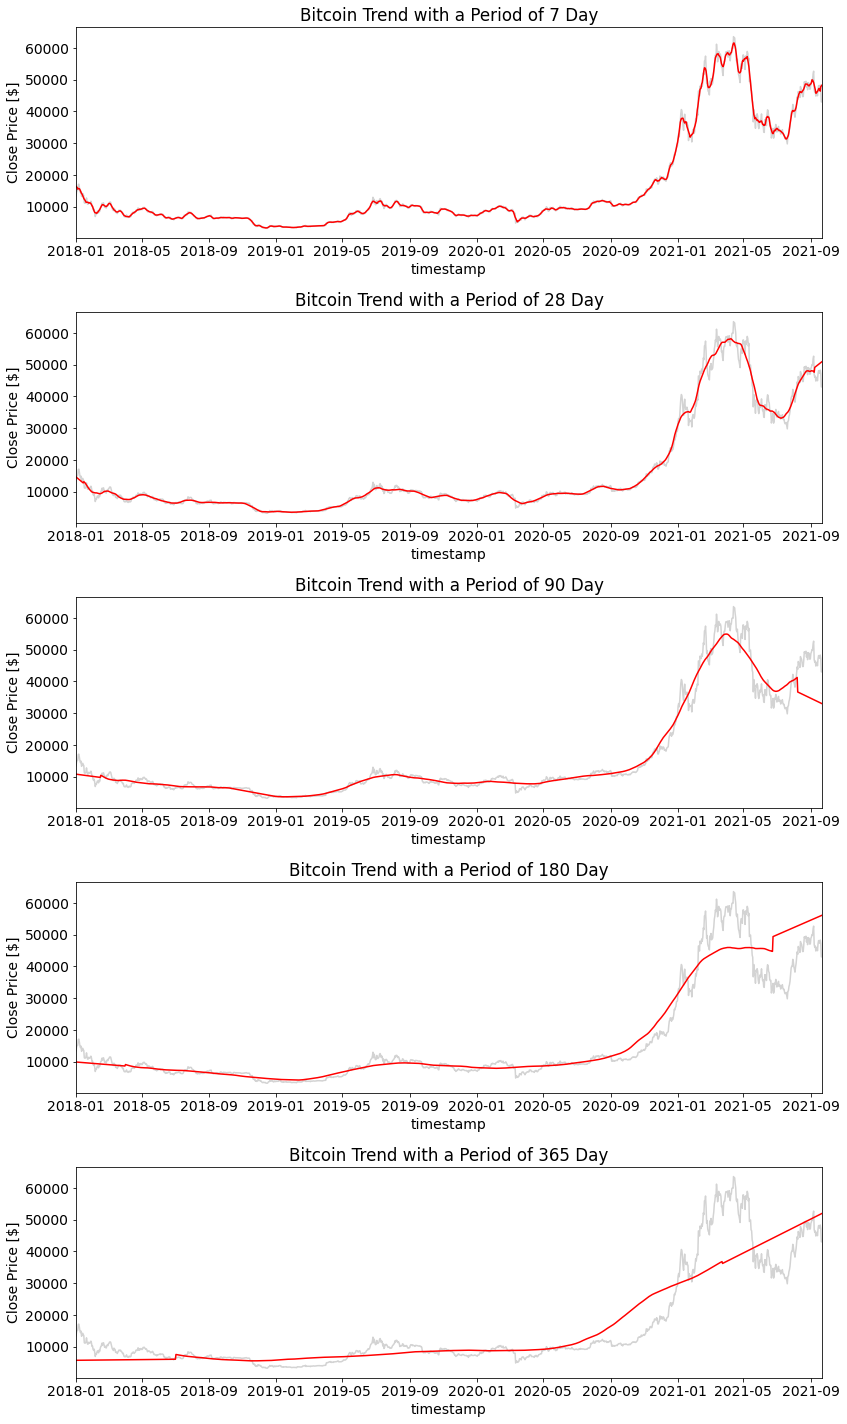

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

periods = [7, 28, 90, 180, 365]
   
asset_id = 1 # Bitcoin
# Visualize
f, ax = plt.subplots(nrows=len(periods), ncols=1, figsize=(12, 20))
for i, p in enumerate(periods):
    decomp = seasonal_decompose(train_daily[('Close',  asset_id)].fillna(0), period=p, model='additive', extrapolate_trend='freq')
    train_daily[('Trend',  asset_id)] = np.where(train_daily[('Close',  asset_id)].isna(), np.NaN, decomp.trend) #decomp.trend
    
    
    sns.lineplot(data=train_daily, x='timestamp', y = ('Close',  asset_id) , ax=ax[i], color='lightgrey');
    sns.lineplot(data=train_daily, x='timestamp', y = ('Trend',  asset_id) , ax=ax[i], color='red');
    ax[i].set_title(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]} Trend with a Period of {p} Day")
    ax[i].set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
    #ax[i].set_ylim([-0.6,0.6])
    ax[i].set_ylabel('Close Price [$]')
    
#plt.suptitle(f'Underlying Trend with {PERIOD} day period\n')
plt.tight_layout()
plt.show()

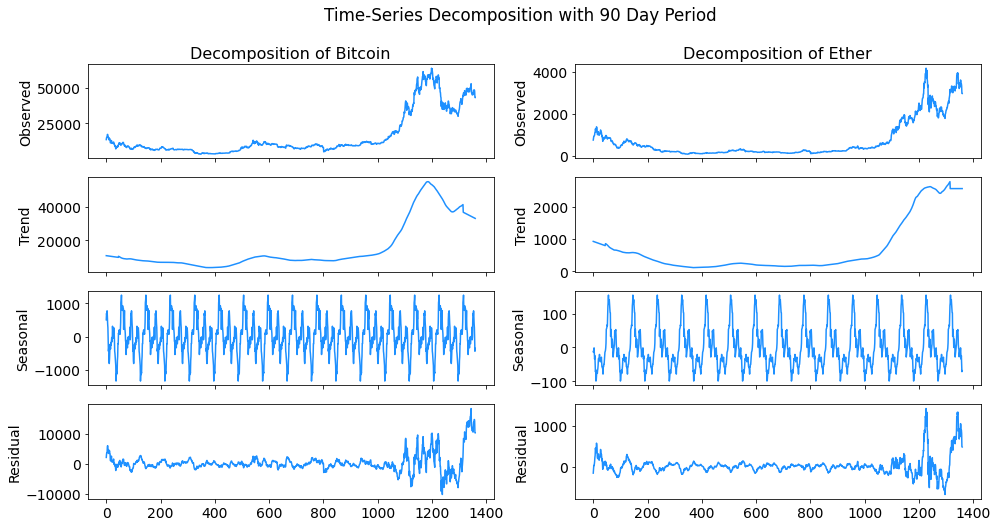

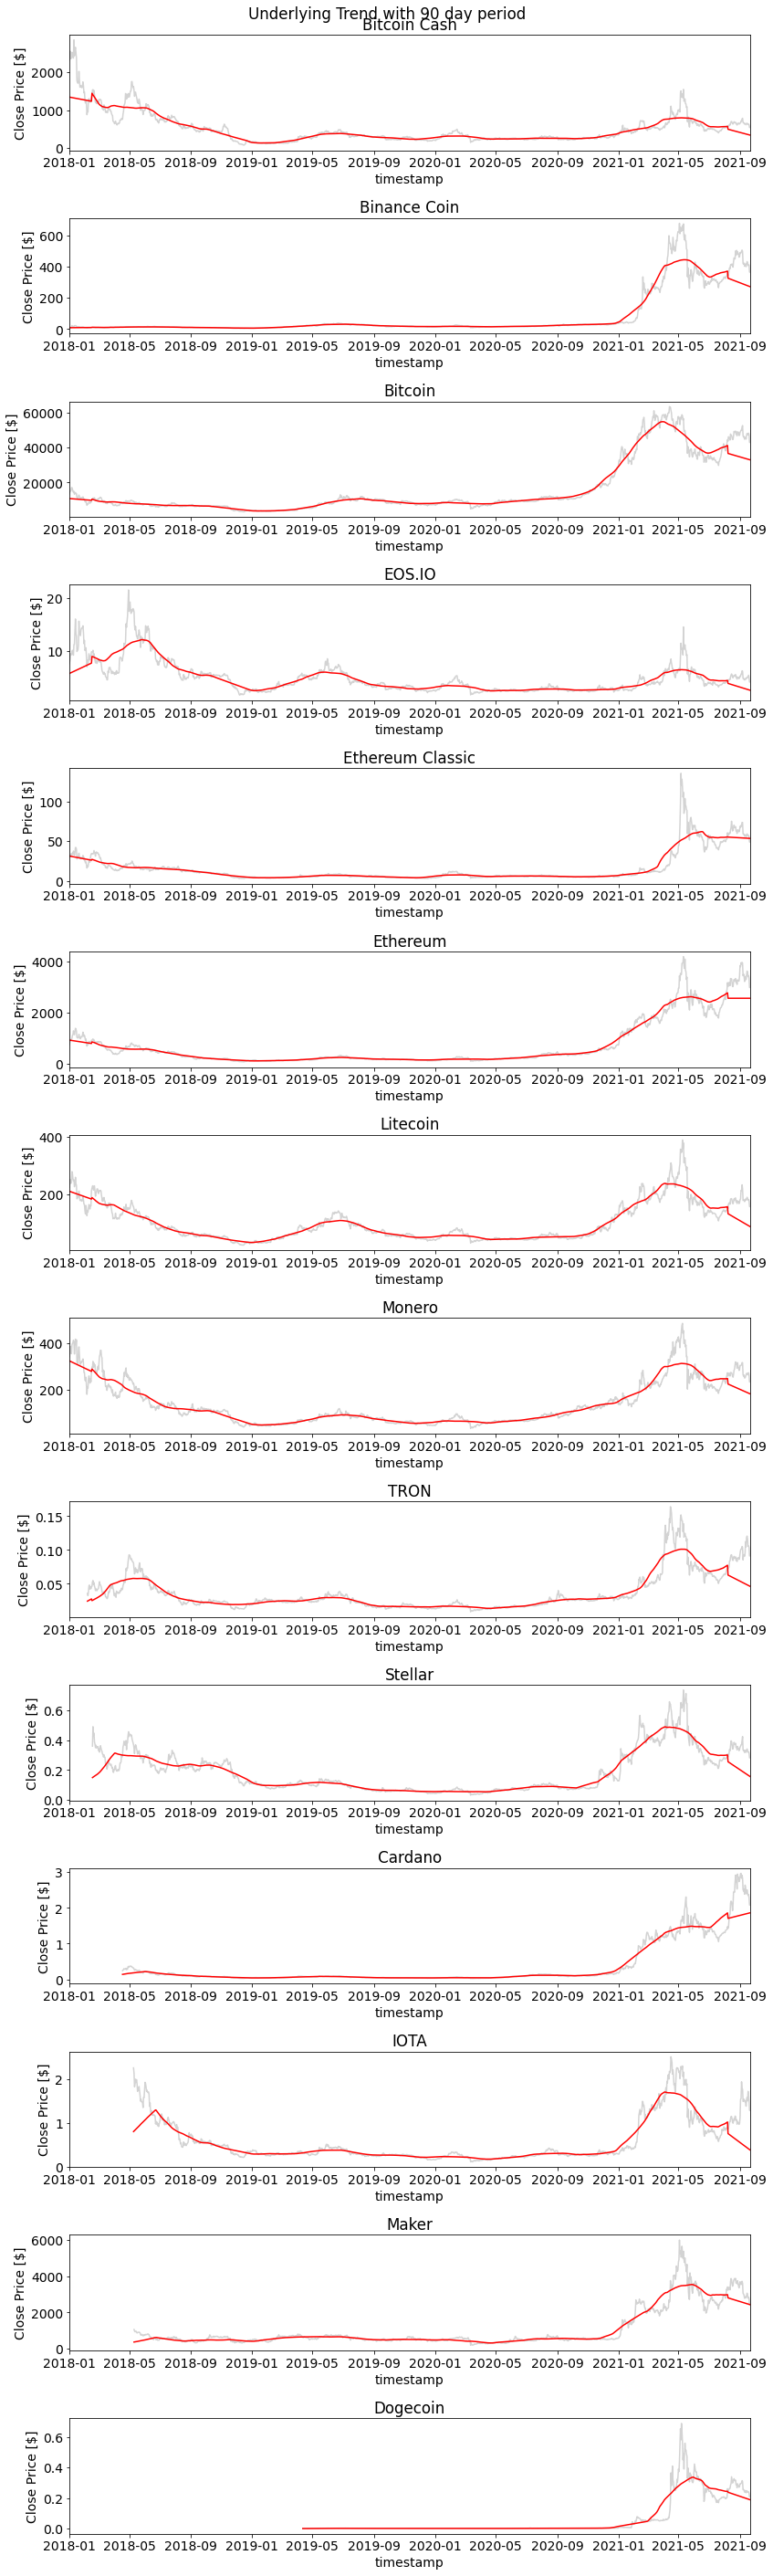

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

PERIOD = 90
for i, asset_id in enumerate(asset_details.Asset_ID):    
    decomp = seasonal_decompose(train_daily[('Close',  asset_id)].fillna(0), period=PERIOD, model='additive', extrapolate_trend='freq')
    train_daily[('Trend',  asset_id)] = np.where(train_daily[('Close',  asset_id)].isna(), np.NaN, decomp.trend) #decomp.trend
    train_daily[('Seasonal',  asset_id)] = np.where(train_daily[('Close',  asset_id)].isna(), np.NaN, decomp.seasonal)# decomp.seasonal
    
    
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

res = seasonal_decompose(train_daily[('Close',  1)], period=PERIOD, model='additive', extrapolate_trend='freq')

ax[0,0].set_title('Decomposition of Bitcoin', fontsize=16)
res.observed.plot(ax=ax[0,0], legend=False, color='dodgerblue')
ax[0,0].set_ylabel('Observed', fontsize=14)
#ax[0,0].set_ylim([-5, 35])

res.trend.plot(ax=ax[1,0], legend=False, color='dodgerblue')
ax[1,0].set_ylabel('Trend', fontsize=14)
#ax[1,0].set_ylim([-5, 35])

res.seasonal.plot(ax=ax[2,0], legend=False, color='dodgerblue')
ax[2,0].set_ylabel('Seasonal', fontsize=14)
#ax[2,0].set_ylim([-15, 15])

res.resid.plot(ax=ax[3,0], legend=False, color='dodgerblue')
ax[3,0].set_ylabel('Residual', fontsize=14)
#ax[3,0].set_ylim([-15, 15])


res = seasonal_decompose(train_daily[('Close',  6)], period=PERIOD, model='additive', extrapolate_trend='freq')

ax[0,1].set_title('Decomposition of Ether', fontsize=16)
res.observed.plot(ax=ax[0,1], legend=False, color='dodgerblue')
ax[0,1].set_ylabel('Observed', fontsize=14)
#ax[0,0].set_ylim([-5, 35])

res.trend.plot(ax=ax[1,1], legend=False, color='dodgerblue')
ax[1,1].set_ylabel('Trend', fontsize=14)
#ax[1,0].set_ylim([-5, 35])

res.seasonal.plot(ax=ax[2,1], legend=False, color='dodgerblue')
ax[2,1].set_ylabel('Seasonal', fontsize=14)
#ax[2,0].set_ylim([-15, 15])

res.resid.plot(ax=ax[3,1], legend=False, color='dodgerblue')
ax[3,1].set_ylabel('Residual', fontsize=14)
#ax[3,0].set_ylim([-15, 15])

plt.suptitle(f'Time-Series Decomposition with {PERIOD} Day Period')
plt.show()


# Visualize
f, ax = plt.subplots(nrows=len(asset_details.Asset_ID), ncols=1, figsize=(12, 40))
for i, asset_id in enumerate(asset_details.Asset_ID):
    sns.lineplot(data=train_daily, x='timestamp', y = ('Close',  asset_id) , ax=ax[i], color='lightgrey');
    sns.lineplot(data=train_daily, x='timestamp', y = ('Trend',  asset_id) , ax=ax[i], color='red');
    ax[i].set_title(asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0])
    ax[i].set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
    #ax[i].set_ylim([-0.6,0.6])
    ax[i].set_ylabel('Close Price [$]')
    
plt.suptitle(f'Underlying Trend with {PERIOD} day period\n')
plt.tight_layout()
plt.show()

# Moving Average

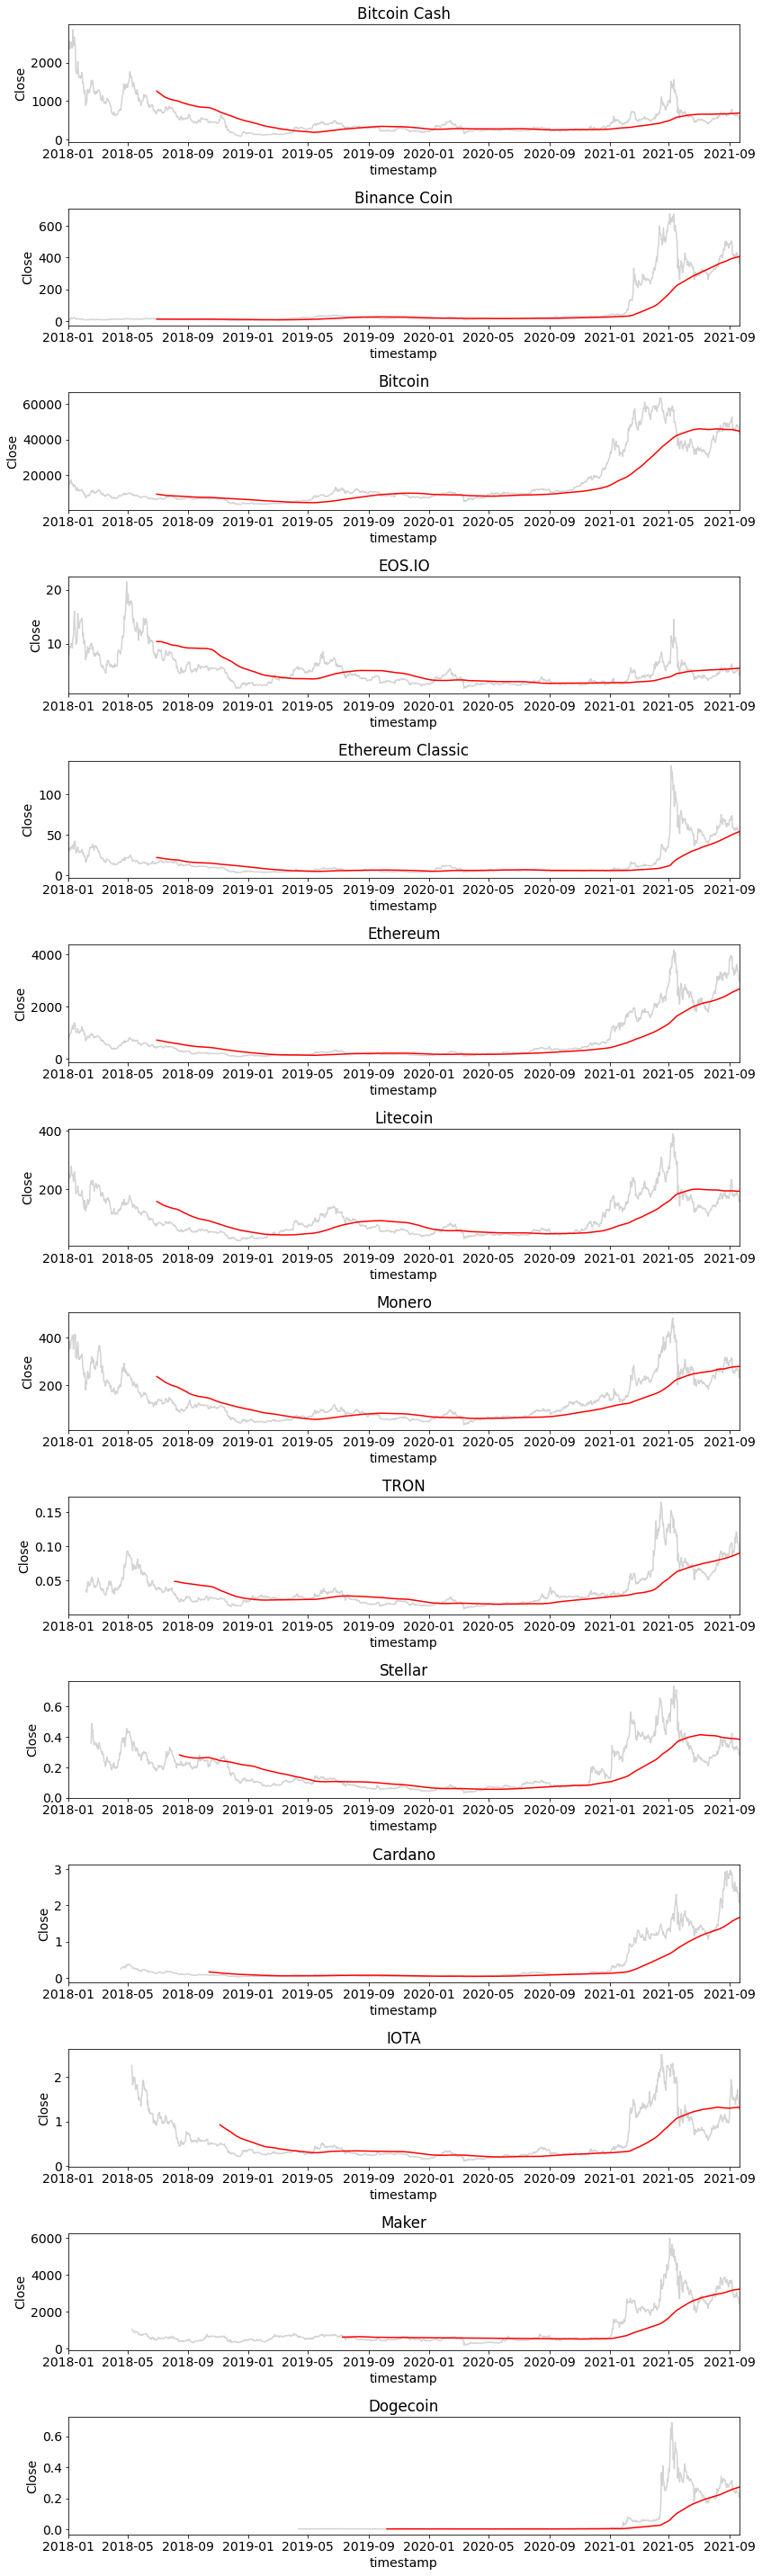

In [16]:
for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('Close_MA',  asset_id)] = train_daily[('Close',  asset_id)].rolling(180).mean()

# Visualize
f, ax = plt.subplots(nrows=len(asset_details.Asset_ID), ncols=1, figsize=(12, 40))
for i, asset_id in enumerate(asset_details.Asset_ID):

    sns.lineplot(data=train_daily, x='timestamp', y = ( 'Close',  asset_id) , ax=ax[i], color='lightgrey');
    sns.lineplot(data=train_daily, x='timestamp', y = ( 'Close_MA',  asset_id) , ax=ax[i], color='red');

    ax[i].set_title(asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0])
    #ax[i].set_xlim([pd.Timestamp('2021-01-01'), train_daily.timestamp.iloc[-1]])
    ax[i].set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
    #ax[i].set_ylim([-0.25,0.25])
    ax[i].set_ylabel('Close')
#plt.suptitle('Log Return\n')

plt.tight_layout()
plt.show()

In [17]:
for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('lret_MA',  asset_id)] = train_daily[('lret',  asset_id)].rolling(7).mean()


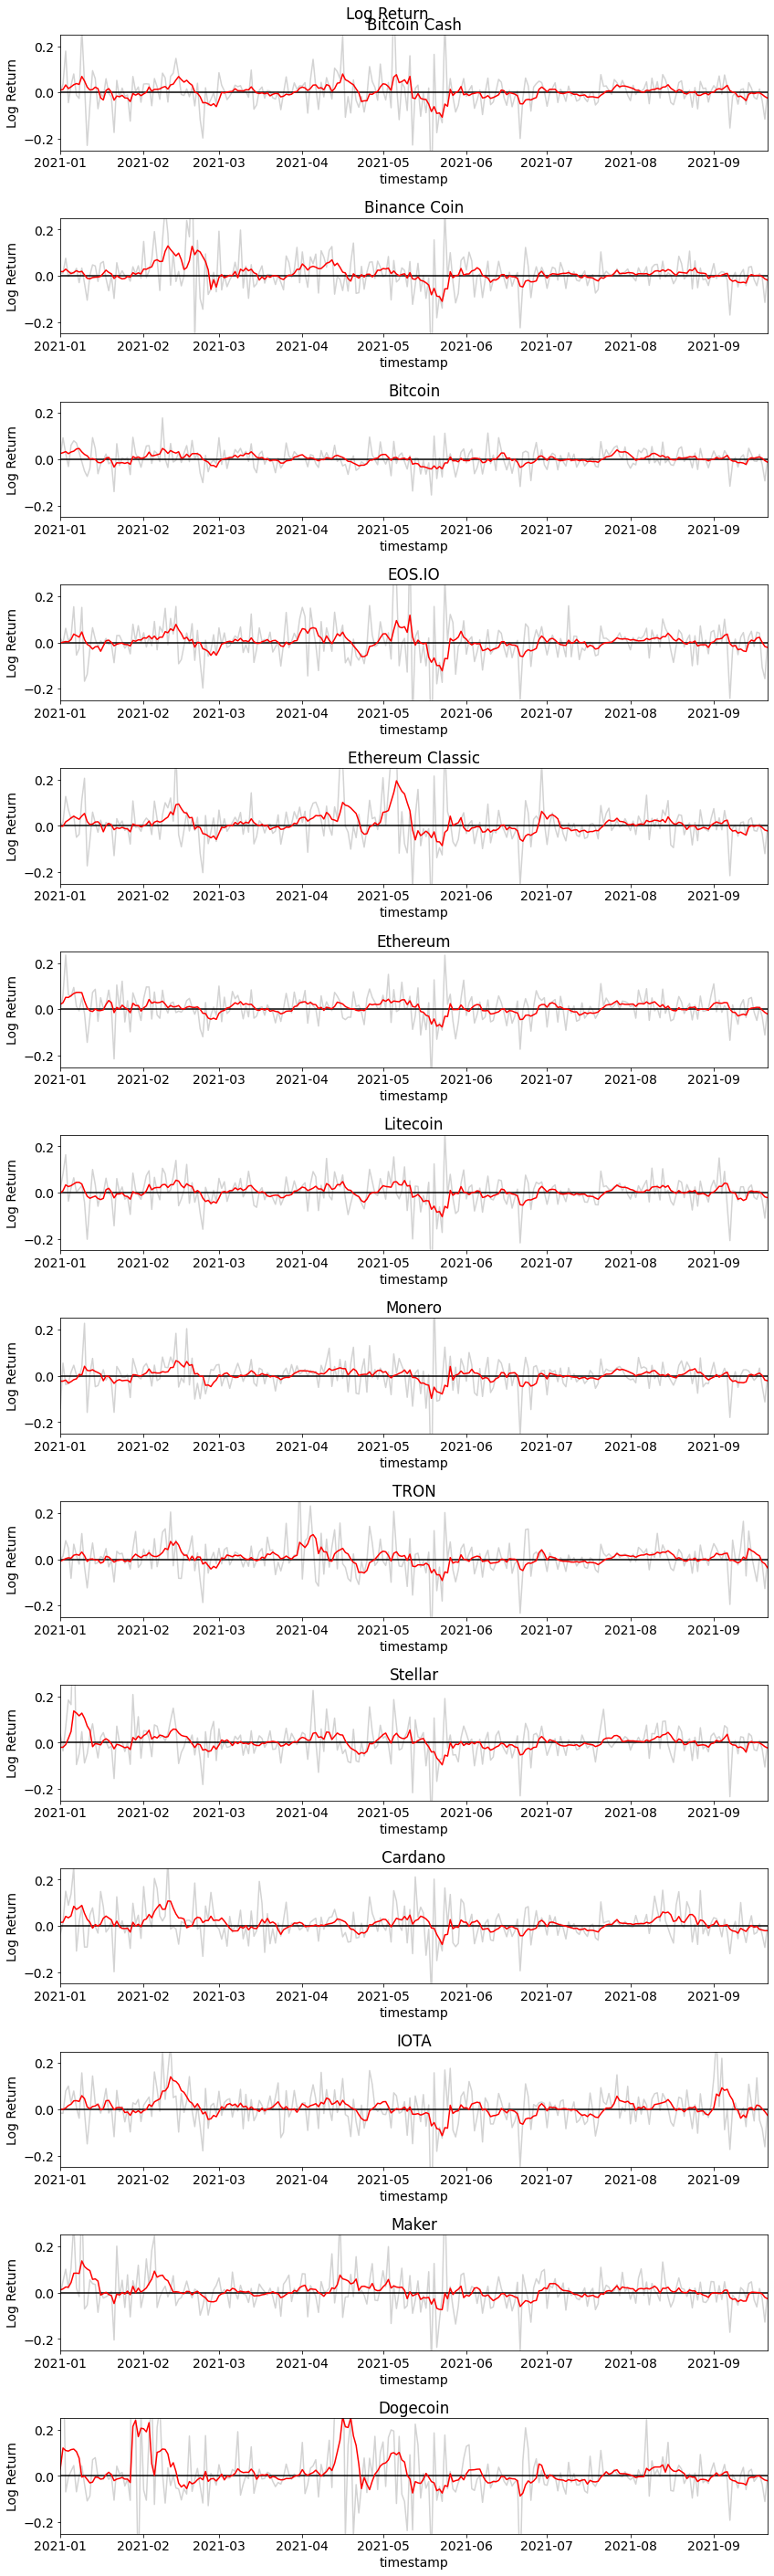

In [18]:
# Visualize
f, ax = plt.subplots(nrows=len(asset_details.Asset_ID), ncols=1, figsize=(12, 40))
for i, asset_id in enumerate(asset_details.Asset_ID):

    sns.lineplot(data=train_daily, x='timestamp', y = ( 'lret',  asset_id) , ax=ax[i], color='lightgrey');
    sns.lineplot(data=train_daily, x='timestamp', y = 0 , ax=ax[i], color='black');
    sns.lineplot(data=train_daily, x='timestamp', y = ( 'lret_MA',  asset_id) , ax=ax[i], color='red');

    ax[i].set_title(asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0])
    ax[i].set_xlim([pd.Timestamp('2021-01-01'), train_daily.timestamp.iloc[-1]])
    ax[i].set_ylim([-0.25,0.25])
    ax[i].set_ylabel('Log Return')
plt.suptitle('Log Return\n')

plt.tight_layout()
plt.show()

## Altcoin Season

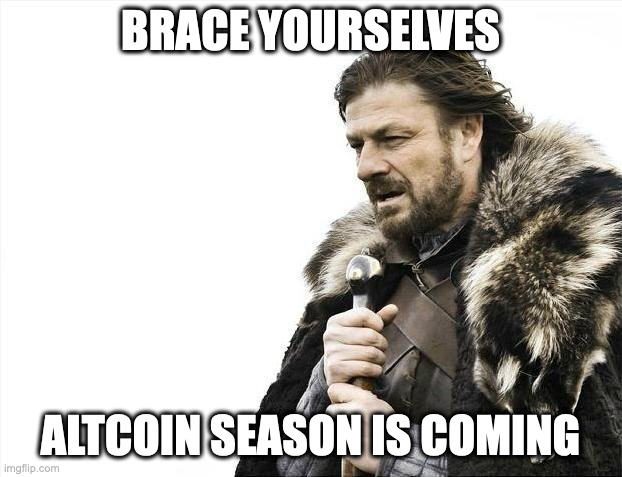

The term *altcoins* refers to all cryptocurrencies other than Bitcoin.

> If 75% of the Top 50 coins performed better than Bitcoin over the last season (90 days) it is Altcoin Season. Excluded from the Top 50 are Stablecoins (Tether, DAI…) and asset backed tokens (WBTC, stETH, cLINK,…) - [Altcoin Season Index on blockchaincenter.net](https://www.blockchaincenter.net/altcoin-season-index/)

# Feature Engineering

Upper Shadow and Lower Shadow as shown in the [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)

In [19]:
for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('upper_shadow',  asset_id)] = train_daily[('High',  asset_id)] - np.maximum(train_daily[('Close',  asset_id)], train_daily[('Open',  asset_id)])
    train_daily[('lower_shadow',  asset_id)] = np.minimum(train_daily[('Close',  asset_id)], train_daily[('Open',  asset_id)]) - train_daily[('Low',  asset_id)]

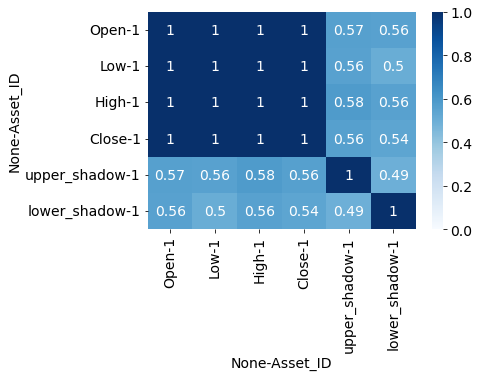

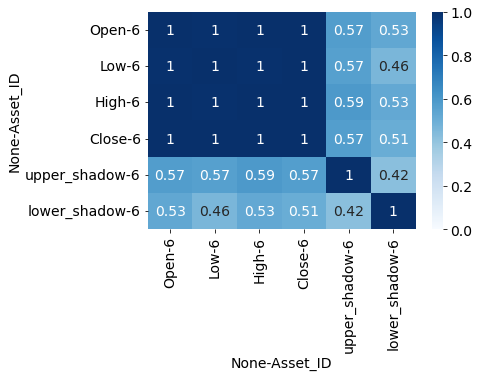

In [20]:
asset_id = 1

temp = train_daily[[('Open',  asset_id), ('Low',  asset_id), ('High',  asset_id), ('Close',  asset_id), ('upper_shadow',  asset_id), ('lower_shadow',  asset_id)]]
sns.heatmap(temp.corr(), vmin=0, vmax=1, cmap='Blues', annot=True)
plt.show()

asset_id = 6

temp = train_daily[[('Open',  asset_id), ('Low',  asset_id), ('High',  asset_id), ('Close',  asset_id), ('upper_shadow',  asset_id), ('lower_shadow',  asset_id)]]
sns.heatmap(temp.corr(), vmin=0, vmax=1, cmap='Blues', annot=True)
plt.show()

# Monthly Resampling

In [21]:
# Resample
train_monthly = pd.DataFrame()

for asset_id in asset_details.Asset_ID:
    train_single = train[train.Asset_ID == asset_id].copy()

    train_single_new = train_single[['timestamp','Count']].resample('MS', on='timestamp').sum()
    train_single_new['Close'] = train_single[['timestamp','Close']].resample('D', on='timestamp').mean()['Close']
    train_single_new['Asset_ID'] = asset_id

    train_monthly = train_monthly.append(train_single_new.reset_index(drop=False))
train_monthly = train_monthly.sort_values(by = ['timestamp', 'Asset_ID']).reset_index(drop=True)

train_monthly = train_monthly.pivot(index='timestamp', columns='Asset_ID')[['Close']]
train_monthly = train_monthly.reset_index(drop=False)
train_monthly['year'] = pd.DatetimeIndex(train_monthly['timestamp']).year
train_monthly['month'] = pd.DatetimeIndex(train_monthly['timestamp']).month

display(train_monthly.head(10))

timestamp      Close                                           \
Asset_ID                     0             1            2         3   4   
0        2018-01-01   8.269135  13440.450886  2340.811743       NaN NaN   
1        2018-02-01  10.142761   9578.447154  1368.834375       NaN NaN   
2        2018-03-01  10.516375  10649.993223  1256.003736       NaN NaN   
3        2018-04-01  10.933150   6795.433948   659.833996       NaN NaN   
4        2018-05-01  13.953424   8990.257843  1296.871136  0.340511 NaN   
5        2018-06-01  14.060228   7481.128462   992.932964  0.219896 NaN   
6        2018-07-01  14.393188   6351.611730   734.749617  0.138512 NaN   
7        2018-08-01  13.551826   7569.856095   757.271181  0.139273 NaN   
8        2018-09-01  11.343509   7106.879634   581.255682  0.105844 NaN   
9        2018-10-01   9.960883   6593.906884   532.935796  0.084565 NaN   

                                                                              \
Asset_ID          5            6          7         8           9         10   
0          7.640769   745.618867  29.187259       NaN  223.975443        NaN   
1         10.819243  1091.206619  26.458423       NaN  152.513827        NaN   
2          8.349248   865.544431  33.228337       NaN  208.286418        NaN   
3          5.656404   381.384453  13.818367       NaN  114.331721        NaN   
4         17.218383   657.379803  21.039507       NaN  145.445137        NaN   
5         12.135961   575.721860  15.279869  1.828565  118.707519  767.83125   
6          8.022384   451.452170  15.982385  1.028919   79.718736  597.70000   
7          7.235977   420.629084  15.929633  0.924926   77.425634  614.31625   
8          6.657125   290.371036  13.065899  0.734001   64.830742  450.70750   
9          5.692474   230.293459  11.256151  0.564631   60.685042  469.72000   

                                          year month  
Asset_ID          11        12        13              
0         330.970663       NaN       NaN  2018     1  
1         256.349554       NaN       NaN  2018     2  
2         298.200128  0.334502  0.045045  2018     3  
3         173.601663  0.200216  0.032136  2018     4  
4         234.465613  0.423747  0.089200  2018     5  
5         155.458274  0.289359  0.058378  2018     6  
6         129.397023  0.193453  0.037155  2018     7  
7         123.293138  0.272501  0.032865  2018     8  
8         120.734759  0.228048  0.026167  2018     9  
9         115.088938  0.259934  0.022076  2018    10

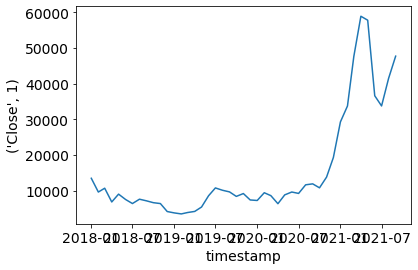

Bitcoin: Non-stationary
ADF Statistic: 1.238729
p-value: 0.996243
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608




In [22]:
sns.lineplot(data=train_monthly,x='timestamp',y=('Close',1))
plt.show()
check_stationarity(train_monthly[('Close',1)], 1)


Bitcoin: Stationary
ADF Statistic: -5.569077
p-value: 0.000001
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603




<AxesSubplot:xlabel='timestamp', ylabel="('lret', 1)">

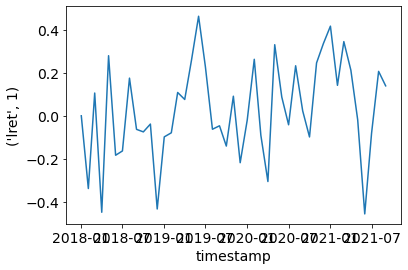

In [23]:
train_monthly[('lret',  1)] = log_return(train_monthly[( 'Close',  1)]).fillna(0)
check_stationarity(train_monthly[('lret',1)], 1)
sns.lineplot(data=train_monthly,x='timestamp',y=('lret',1))

The PACF shows some autocorrelation at lag of 8 and lag of 16. This might be far fetched but maybe we have a period of T=8.

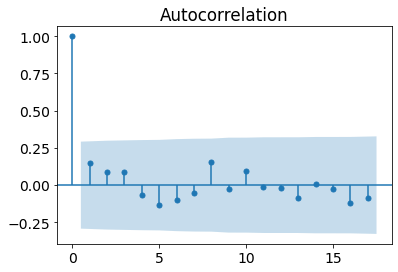

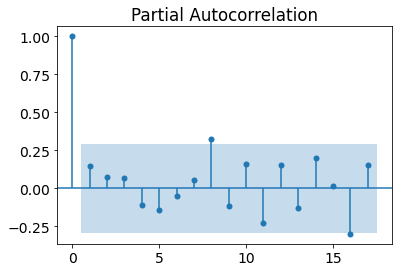

In [24]:
plot_acf(train_monthly[('lret',1)])
plt.show()

plot_pacf(train_monthly[('lret',1)], method='ols')
plt.show()

Let's decompose the monthly time series with a period of T=8.

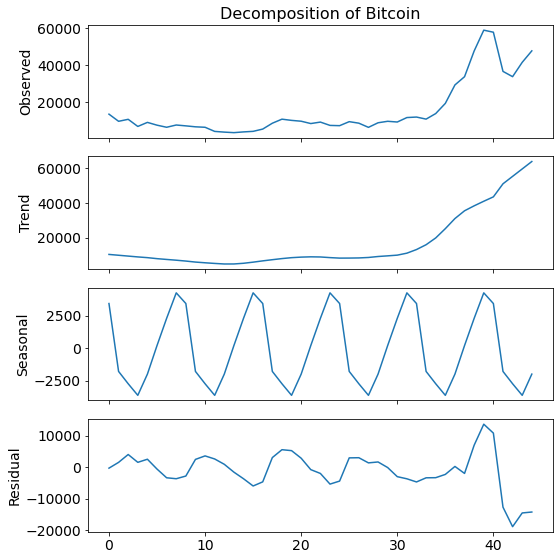

In [25]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,8))

res = seasonal_decompose(train_monthly[('Close',  1)], period=8, model='additive', extrapolate_trend='freq')

ax[0].set_title('Decomposition of Bitcoin', fontsize=16)
res.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')
#ax[0,0].set_ylim([-5, 35])

res.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')
#ax[1,0].set_ylim([-5, 35])

res.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')
#ax[2,0].set_ylim([-15, 15])

res.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')
#ax[3,0].set_ylim([-15, 15])

plt.tight_layout()
plt.show()

# Other Time Series Forecasting Notebooks

- [Intro to Time Series Forecasting](https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting)
- [Time Series Forecasting: Building Intuition](https://www.kaggle.com/iamleonie/time-series-forecasting-building-intuition)
- [Time Series: Interpreting ACF and PACF](https://www.kaggle.com/iamleonie/time-series-interpreting-acf-and-pacf)
